In [1]:
import numpy as np
import copy
from IPython.display import HTML
from matplotlib import pyplot as plt, colors
import dill

import SimPEG as simpeg
from SimPEG.EM import NSEM

import sys
from pymatsolver import PardisoSolver
import telluricpy

# Set some matplotlib settings
%matplotlib notebook

In [2]:
# Define the area of interest
bw, be = -500., 500
bs, bn = -25., 25.
bb, bt = -500.,0.

In [3]:
#Cell size
csx, csy, csz = 10.,10.,10.
# Number of core cells in each directiPon s
ncx, ncy, ncz = 20,20,25.
# Number of core cells in each directiPon s
# ncx, ncy, ncz = int((be - bw)/csx), int((bn - bs)/csy), int((bt - bb)/csz)
# Number of padding cells to add in each direction
npad = 9
growrate = 1.5
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -growrate),(csx,ncx),(csx,npad,growrate)]
hy = [(csy,npad, -growrate),(csy,ncy),(csy,npad, growrate)]
hz = [(csz,npad,-growrate),(csz,ncz),(csy,npad, growrate)]
#hz = [(csz,npad, -1.5),(csz,ncz),(csz,npad,1.5)]

# nrCcore = [6, 5, 4, 2, 2, 2, 2]
airPad = simpeg.Utils.meshTensor([(csz,npad,growrate)])
# vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(csz,1),(csz,5,1.3)])))])[::-1]
# botPad = simpeg.Utils.meshTensor([(vCore[0],2,-1.5)])
# hz = np.concatenate((botPad,vCore,airPad))

# Create mesh
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
mesh.x0[2] = mesh.x0[2]+np.sum(airPad) + 100
#mesh.x0[2] = mesh.x0[2]- csz/2.#-np.max(mesh.vectorCCz[npad:-npad]) 

# mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
# mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
# mesh.plotGrid()
# plt.gca().set_aspect('equal')
# plt.show()

print mesh.nC
print mesh.nF

62092
190988


In [4]:
sig_air = 1e-8
sphere_depth = 100.
sig_back = 1e-2
sig_sphere = 1e-1
sphere_r = 50.
sigma = sig_back*np.ones(mesh.nC)

#air cells
air = mesh.gridCC[:,2]>0.
sigma[air]=sig_air
bgsigma
#Define the layer limit
layer = (mesh.gridCC[:,2] < -50.) * (mesh.gridCC[:,2] > -150.)
sigma[layer] = sig_sphere

# Get a 1D background model
bgsigma = mesh.r(sigma,'CC','CC','M')[0,0,:]

<IPython.core.display.Javascript object>


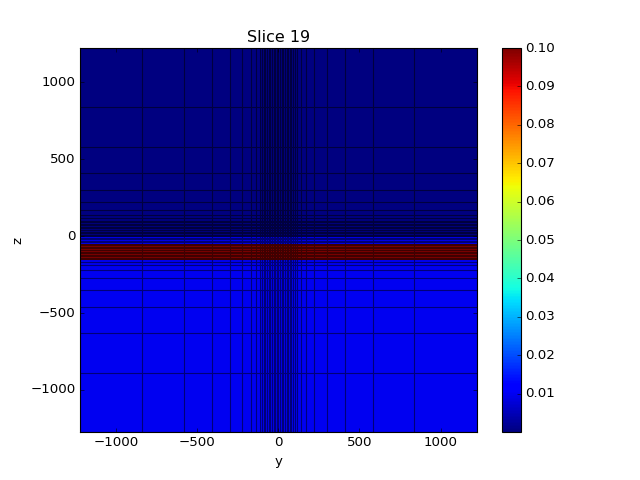

In [27]:
a = mesh.plotSlice(sigma, grid=True, normal="X")
# plt.gca().set_xlim([-250.,250])
# plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

In [9]:
# Make the rxLocations file
x,y,z = np.meshgrid(np.arange(-100,101,10),np.arange(-100,101,10),[0.])
locs = np.hstack((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)))


In [10]:
freqs = np.logspace(5,-2,29)
print freqs

[  1.00000000e+05   5.62341325e+04   3.16227766e+04   1.77827941e+04
   1.00000000e+04   5.62341325e+03   3.16227766e+03   1.77827941e+03
   1.00000000e+03   5.62341325e+02   3.16227766e+02   1.77827941e+02
   1.00000000e+02   5.62341325e+01   3.16227766e+01   1.77827941e+01
   1.00000000e+01   5.62341325e+00   3.16227766e+00   1.77827941e+00
   1.00000000e+00   5.62341325e-01   3.16227766e-01   1.77827941e-01
   1.00000000e-01   5.62341325e-02   3.16227766e-02   1.77827941e-02
   1.00000000e-02]


In [11]:
rxList = []        
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'imag'))            
for rx_orientation in ['zx','zy']:
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'imag'))
# Source list
srcList =[]
for freq in freqs:
    srcList.append(NSEM.Src.Planewave_xy_1Dprimary(rxList,freq))
# Survey MT
survey = NSEM.Survey(srcList)
# Background 1D model
sigma1d = mesh.r(sigma,'CC','CC','M')[0,0,:]
## Setup the problem object
problem = NSEM.Problem3D_ePrimSec(mesh, sigmaMap=simpeg.Maps.IdentityMap(), sigmaPrimary = sigma1d)
problem.verbose = True

problem.Solver = PardisoSolver
problem.pair(survey)

import time
## Calculate the fields
stTime = time.time()
print 'Starting calculating field solution at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
FmtSer = problem.fields(sigma)
print 'Ended calculation field at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

## Project data
stTime = time.time()
print 'Starting projecting fields to data at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
mtData = NSEM.Data(survey,survey.eval(FmtSer))
print 'Ended projection of fields at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

Starting calculating field solution at 2016-12-28 08:56:07
Starting work for 1.000e-02
Ran for 50.147823 seconds
Starting work for 1.778e-02
Ran for 49.660812 seconds
Starting work for 3.162e-02
Ran for 48.904062 seconds
Starting work for 5.623e-02
Ran for 49.445264 seconds
Starting work for 1.000e-01
Ran for 51.600861 seconds
Starting work for 1.778e-01
Ran for 51.938392 seconds
Starting work for 3.162e-01
Ran for 52.300300 seconds
Starting work for 5.623e-01
Ran for 55.550331 seconds
Starting work for 1.000e+00
Ran for 53.284210 seconds
Starting work for 1.778e+00
Ran for 50.065547 seconds
Starting work for 3.162e+00
Ran for 45.603840 seconds
Starting work for 5.623e+00
Ran for 42.752581 seconds
Starting work for 1.000e+01
Ran for 49.186054 seconds
Starting work for 1.778e+01
Ran for 44.398442 seconds
Starting work for 3.162e+01
Ran for 42.279618 seconds
Starting work for 5.623e+01
Ran for 44.173837 seconds
Starting work for 1.000e+02
Ran for 53.041817 seconds
Starting work for 1.778

In [13]:
# Pickle the data
mtData.survey.unpair()

dill.dump(mtData,open('sphere_mtData.pklb','wb'))

<IPython.core.display.Javascript object>


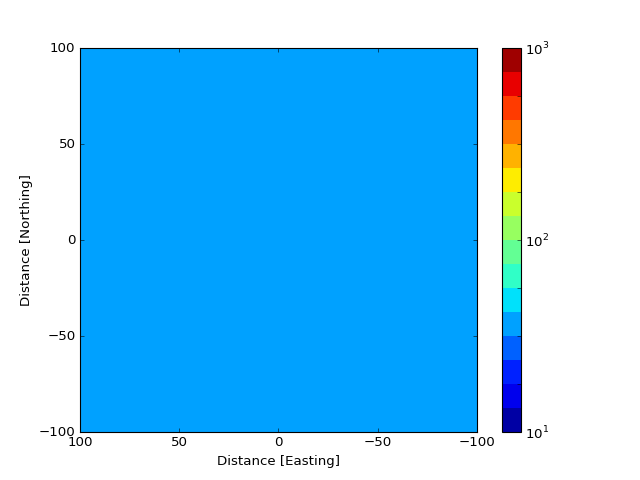

In [14]:
cont_kwargs={'levels':np.logspace(1,3,17),'norm':colors.LogNorm()}
mtData.map_iso_frequency(1000., 'Z', 'xy', component='app_res',ax=None, plot_error=False, **cont_kwargs)
plt.colorbar()

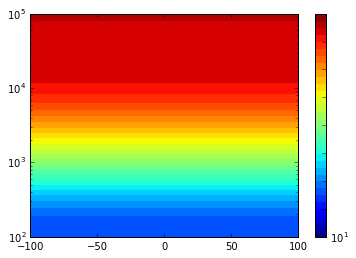

In [21]:
cont_args = {'levels':np.logspace(1,2.2,8*4+1),'norm':colors.LogNorm()}
fig, ax, cont = mtData.section_plot({'y':0.},'Z','xy','app_res',ax=None, plot_error=False, **cont_args)
ax.set_yscale('log')
plt.colorbar(cont)

In [25]:
def plotAnaSolu(axes,mesh1d,model1d,elevation,notUsed):
    from SimPEG.EM.NSEM.Utils import plotDataTypes as pDt
    from numpy.lib.recfunctions import rec_append_fields
    freqList = np.logspace(5,-3,41)
    anaRecArr = NSEM.Utils.dataUtils.makeAnalyticSolution(mesh1d,model1d,elevation,freqList)
    anaRecArr = rec_append_fields(anaRecArr,'zxy',-anaRecArr['zyx'])
    # Appres
    pDt.plotIsoStaImpedance(axes[0],np.array([0,0]),anaRecArr,'zyx','res',pSym='x',pColor='k')
    # Appphs
    pDt.plotIsoStaImpedance(axes[1],np.array([0,0]),anaRecArr,'zxy','phs',pSym='x',pColor='k')
    pDt.plotIsoStaImpedance(axes[1],np.array([0,0]),anaRecArr,'zyx','phs',pSym='x',pColor='k')
    
def plotAppRes(data,plotLoc,pCol='b'):
    ''' Plots amplitude impedance and phase'''
    # fig = plt.figure(1,(7, 7))

    fig,axT=plt.subplots(2,1,sharex=True)
    axes = axT.ravel()
#     fig.set_size_inches((3.3,2.5))
    fig.set_dpi(200)
    fig.suptitle('{:s}\nStation at: {:.1f}x ; {:.1f}y'.format('MT responses',plotLoc[0],plotLoc[1]))
    # Have to deal with axes
    # Set log
    for ax in axes.ravel():
        ax.set_xscale('log')

    axes[0].invert_xaxis()
    axes[0].set_yscale('log')
    # Set labels
    axes[0].set_xlabel('Frequency [Hz]')
#     axes[0].set_ylim(1e0,1e4)
    axes[1].set_xlabel('Frequency [Hz]')
    axes[0].set_ylabel('Apperent resistivity [Ohm m]')
    axes[1].set_ylabel('Apperent phase [degrees]')
    
#     axes[1].set_xlim(10000,1e-3)    
    
    data.plot_app_res(plotLoc, ax=axes[0])
    data.plot_app_phs(plotLoc, ax=axes[1])
            
    return fig, axes

m1d = simpeg.Mesh.TensorMesh([mesh.hz],x0=np.array([mesh.x0[2]]))

<IPython.core.display.Javascript object>


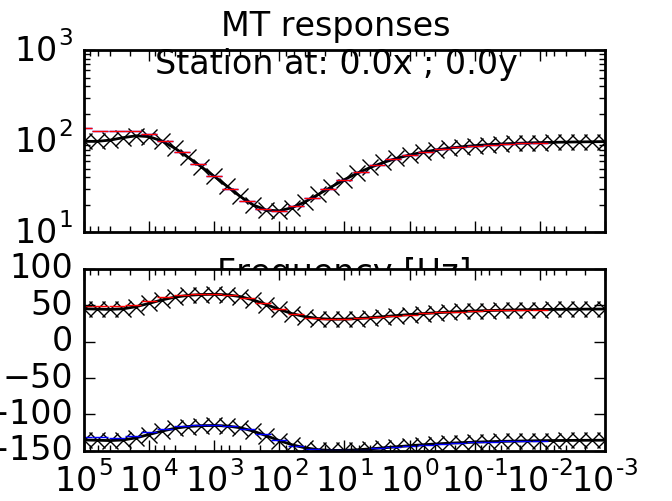

In [26]:
fig, axes = plotAppRes(mtData,np.array([0.,0.]))
plotAnaSolu(axes, m1d, bgsigma, np.array([0.]),10)